# Example of the matrix being inverted for the eigenvalues getting illegal values.

This is an error that appears occassionally, which looks something like:
** On entry to DHSEQR parameter number  4 had an illegal value

This possibly has something to do with a nan or inf in the matrix being inverted for the eigenvalue problem. For some reason it doesn't seem to crash Dynesty.

The objective of this notebook is to reproduce the error with a simple example.

In [1]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import corner
import jax.numpy as jnp
import pbjam.distributions as dist
import numpy as np
from scipy.linalg import eigh as seigh
import matplotlib.pyplot as plt
import jax
import scipy
from pbjam.jar import constants as c


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


## Load in some dummy data so we can initialize the class

In [2]:
psd = IO.psd('KIC7976303', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::10]

s = psd.powerdensity[::10]

Using cached search result.
Loading fits files from cache.


## Priors and Observations
The addObs dictionary is used to select the relevant target range of the prior.

The addPriors dictionary is used to specify independent priors for each of the listed parameters. These are *not* included in the dimensionality reduction.

In [3]:
addObs = {'numax' : (900.17, 80),
          'dnu'  : (51.24, 0.21),
          'teff': (6053, 10.0),
          'bp_rp': (0.719, 0.05), 
          } 

addPriors = {'u1' : dist.beta(a=1.2, b=1.2, loc=-0.05, scale=0.17),
             'u2' : dist.beta(a=1.2, b=1.2, loc=-0.05, scale=0.17),
             'DPi0': dist.normal(loc=0.000500, scale=0.000500*0.1),
             'eps_g': dist.normal(loc=0.81, scale=0.01),
             'd01': dist.normal(loc=24, scale=1),
             'alpha_g': dist.normal(loc=np.log10(0.002), scale=0.5),
            }

## Initialize the sampling class
This is effectively asy_peakbag from the old version of PBjam.

In [4]:
N_p = 15 # p-mode orders

N_pca = 200 # Number of samples to used for PCA

PCAdims = 8 # Number dimensions for the latent space.
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits = [100, 2000])

## Sample that produces nan

This is just an example of a sample drawn from the prior above which produces a nan frequency.

Note that numax is very small, corresponding to a red giant perhaps. In contrast, the prior we have specified above assumes we're looking at a subgiant star. 

I think this is where the issue comes from.

In [14]:
ubad = [0.86615288, 0.23499165, 0.26577222, 0.94687313, 0.61770512, 0.70032985,
        0.89496718, 0.45228013, 0.07493094, 0.91190697, 0.96810442, 0.31774267,
        0.77226106, 0.43513095, 0.80727484, 0.75582,    0.97785492, 0.50767771,
        0.30856025, 0.27864934, 0.07716695]

ugood = [0.20220363, 0.31185011, 0.14087589, 0.74370002, 0.54311765, 0.04880787,
         0.55723347, 0.90561074, 0.2999131,  0.6969999,  0.21885876, 0.47010355,
         0.14000833, 0.45436337, 0.90467178, 0.86576119, 0.60646271, 0.14009472,
         0.7824884,  0.88866593, 0.17248618]

umedian = np.zeros(len(ugood))+0.5

u = ugood

v = M.ptform(u)

r = M.unpackParams(v)

nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(r['numax'], r['dnu'], r['eps_p'], r['alpha_p'])
 
nu1_p = nu0_p + r['d01'] 

nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, r['DPi0'], r['eps_g'], r['alpha_g'])

L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, r['p_L'], r['p_D'])

v, w = M.MixFreqModel.eigh(L, D)


# lambdaprime, phi= jax.numpy.linalg.eig(D)

# Dprime = phi.real@jnp.diag(lambdaprime.real)@phi.real.T 

# D_cho_factor = jax.scipy.linalg.cho_factor(Dprime)







# b_inv_a = jax.scipy.linalg.cho_solve(D_cho_factor, L)

# if any(np.isnan(b_inv_a).flatten()):
#     #print(b)
#     plt.imshow(b)
    
#     print(jax.scipy.linalg.cho_factor(D))
    
# v, w = jax.jit(jax.numpy.linalg.eig, backend="cpu")(b_inv_a)

# v = v.real

# w = w.real

# # reorder as ascending in w
# order = jnp.argsort(v)

# v = v.take(order, axis=0)

# w = w.take(order, axis=1)

# # renormalize so v.H @ b @ H == 1
# norm2 = jax.vmap(lambda wi: (wi.conj() @ b @ wi).real, in_axes=1)(w)

# norm = jnp.sqrt(norm2)

# w = w / norm

# w = M.MixFreqModel.standardize_angle(w, b)

In [15]:
v, w

(Array([-2.55709049e-04, -2.36786889e-04, -2.18879815e-04, -2.01795714e-04,
        -1.85491812e-04, -1.69957110e-04, -1.55204289e-04, -1.41294559e-04,
        -1.28470427e-04, -1.17809391e-04, -1.09939338e-04, -1.00416700e-04,
        -8.97997177e-05, -7.94362179e-05, -6.96435962e-05, -6.05513496e-05,
        -4.58989220e-05, -2.53805177e-05, -1.59772018e-05, -1.09608189e-05,
        -7.97860587e-06, -6.06415943e-06, -4.76303517e-06, -3.83888002e-06],      dtype=float64),
 Array([[ 5.51748518e-03,  4.78785635e-03,  4.69591070e-03,
          4.90172893e-03,  5.43693174e-03,  6.48555658e-03,
          8.50998792e-03,  1.27616135e-02,  2.32692089e-02,
          4.88120293e-02,  5.80058942e-02,  3.86398244e-02,
          3.03261155e-02,  3.09464430e-02,  4.24575199e-02,
          9.83231578e-01,  1.47230834e-01,  3.33963761e-02,
          1.61646310e-02,  9.63242558e-03,  6.29373215e-03,
          4.25975591e-03,  2.80187985e-03,  1.44747585e-03],
        [ 6.00401000e-03,  5.22603267e-03

In [6]:
v, w

(Array([-2.55709049e-04, -2.36786889e-04, -2.18879815e-04, -2.01795714e-04,
        -1.85491812e-04, -1.69957110e-04, -1.55204289e-04, -1.41294559e-04,
        -1.28470427e-04, -1.17809391e-04, -1.09939338e-04, -1.00416700e-04,
        -8.97997177e-05, -7.94362179e-05, -6.96435962e-05, -6.05513496e-05,
        -4.58989220e-05, -2.53805177e-05, -1.59772018e-05, -1.09608189e-05,
        -7.97860587e-06, -6.06415943e-06, -4.76303517e-06, -3.83888002e-06],      dtype=float64),
 Array([[ 5.51748518e-03,  4.78785635e-03,  4.69591070e-03,
          4.90172893e-03,  5.43693174e-03,  6.48555658e-03,
          8.50998792e-03,  1.27616135e-02,  2.32692089e-02,
          4.88120293e-02,  5.80058942e-02,  3.86398244e-02,
          3.03261155e-02,  3.09464430e-02,  4.24575199e-02,
          9.83231578e-01,  1.47230834e-01,  3.33963761e-02,
          1.61646310e-02,  9.63242558e-03,  6.29373215e-03,
          4.25975591e-03,  2.80187985e-03,  1.44747585e-03],
        [ 6.00401000e-03,  5.22603267e-03

In [16]:
M

In [ ]:
plt.imshow(D)

In [ ]:
def minors(a):
    A = np.abs(a)
    d = np.sqrt(np.diag(A))
    return A / d[:,None] / d[None, :]

plt.matshow(minors(D))

In [ ]:
plt.imshow(D)
plt.colorbar()

In [ ]:
minors = D - np.diag(np.diag(D))

np.sum(np.abs(minors), axis=1)

In [ ]:
import jax

for i in range(1000):

    u = np.random.uniform(0, 1, len(M.priors))
    v = M.ptform(u)
    r = M.unpackParams(v)
    nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(r['numax'], r['dnu'], r['eps_p'], r['alpha_p'])
    nu1_p = nu0_p + r['d01'] 
    nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, r['DPi0'], r['eps_g'], r['alpha_g'])
    L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, r['p_L'], r['p_D'])
       
    a = M.MixFreqModel.symmetrize(L)

    b = M.MixFreqModel.symmetrize(D)
    
    b_inv_a = jax.scipy.linalg.cho_solve(jax.scipy.linalg.cho_factor(b), a)
    
    v, w = jax.jit(jax.numpy.linalg.eig, backend="cpu")(b_inv_a)

    if all(~np.isnan(b_inv_a).flatten()):
        print(u)
        break
#     v = v.real

#     w = w.real

#     # reorder as ascending in w
#     order = jnp.argsort(v)

#     v = v.take(order, axis=0)

#     w = w.take(order, axis=1)

#     # renormalize so v.H @ b @ H == 1
#     norm2 = jax.vmap(lambda wi: (wi.conj() @ b @ wi).real, in_axes=1)(w)

#     norm = jnp.sqrt(norm2)

#     w = w / norm

#     w = M.MixFreqModel.standardize_angle(w, b)
        
    #M.MixFreqModel.new_modes(L,D);

In [ ]:
Dprime.shape

In [ ]:
 jax.scipy.linalg.cho_factor(Dprime) 

In [ ]:
B.shape

In [19]:
len(n_g)

2

Array([9, 8, 7, 6, 5, 4, 3, 2, 1], dtype=int64)

In [51]:
n_p = jnp.arange(10,10 + M.MixFreqModel.N_p)
nu_p = nu0_p
n_g = M.MixFreqModel.n_g
p_L = jnp.array([3])
p_D = jnp.array([2])


E = jnp.ones((M.MixFreqModel.N_p, M.MixFreqModel.N_g))

L_cross = M.MixFreqModel._wrap_polyval2d(n_p[:, jnp.newaxis], n_g[jnp.newaxis, :], p_L) * (nu_g * c.nu_to_omega)**2
L_cross_prime = E * p_L * (nu_g * c.nu_to_omega)**2

D_cross = M.MixFreqModel._wrap_polyval2d(n_p[:, jnp.newaxis], n_g[jnp.newaxis, :], p_D) * (nu_g[jnp.newaxis, :]) / (nu_p[:, jnp.newaxis])
D_cross_prime = E* p_D * (nu_g[jnp.newaxis, :]) / (nu_p[:, jnp.newaxis])

In [52]:
np.allclose(D_cross, D_cross_prime)

True

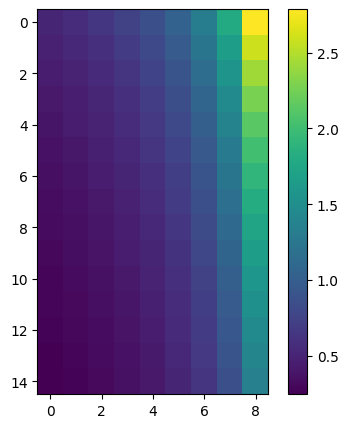

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(D_cross)
plt.colorbar(im)

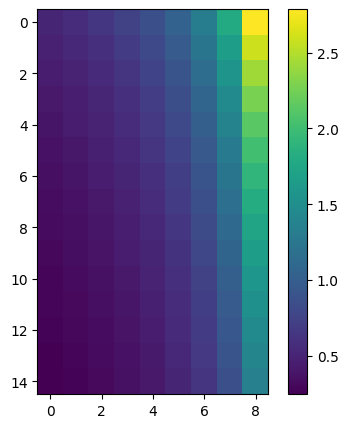

In [50]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(D_cross_prime)
plt.colorbar(im)